## Zachary Adler

zpa2001 

Problem Set 7

In [2]:
#ALL IMPORT STATEMENTS
import math
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import quad
from scipy.special import gammaincc
import kplr
import my_transit as mt

Sample code for problem 7 -- first, use kplr to read in the data

In [3]:
# Find the target KOI.
client = kplr.API()
koi = client.koi(97.01)

# Get a list of light curve datasets.
lcs = koi.get_light_curves(short_cadence=False)

# Open the first dataset and read it
f = lcs[0].open()
hdu_data = f[1].data
f.close()

Next, define func1 and func2, which are the two functions to be integrated to compute the flux theory curve (which is the ratio of the integral(func1)/integral(func2)).

In [4]:
def I(r):
    '''A Limb-darkening function'''
    mu = (1 - (r**2))**(0.5)
    return 1 - (1 - (mu**(0.5)))

def func1(r, p, z):
    return I(r) * (1 - mt.delta(p,r,abs(z))) * 2 * r

def func2(r, p, z):
    return I(r) * 2 * r

In [5]:
#these are the names of the 'keys' in the astropy.io.fits.fitsrec.FITS_rec object 'hdu_data'
#I'll be using SAP_FLUX, SAP_FLUX_ERR, AND TIME
hdu_data.columns

ColDefs(
    name = 'TIME'; format = 'D'; unit = 'BJD - 2454833'; disp = 'D14.7'
    name = 'TIMECORR'; format = 'E'; unit = 'd'; disp = 'E13.6'
    name = 'CADENCENO'; format = 'J'; disp = 'I10'
    name = 'SAP_FLUX'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'SAP_FLUX_ERR'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'SAP_BKG'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'SAP_BKG_ERR'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'PDCSAP_FLUX'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'PDCSAP_FLUX_ERR'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'SAP_QUALITY'; format = 'J'; disp = 'B16.16'
    name = 'PSF_CENTR1'; format = 'D'; unit = 'pixel'; disp = 'F10.5'
    name = 'PSF_CENTR1_ERR'; format = 'E'; unit = 'pixel'; disp = 'E14.7'
    name = 'PSF_CENTR2'; format = 'D'; unit = 'pixel'; disp = 'F10.5'
    name = 'PSF_CENTR2_ERR'; format = 'E'; unit = 'pixel'; disp = 'E14.7'
    name = 'MOM_CENTR1'; format = 'D'; uni

### Problem 1

In [6]:
#'First, extract the data in the time range 124 < t < 125'
idx = np.where((hdu_data["time"] > 124) & (hdu_data["time"] < 125))
t = hdu_data["time"][idx]
flux = hdu_data["sap_flux"][idx]
err = hdu_data["sap_flux_err"][idx]

#'we will need to normalize the stellar flux'
#compute clipped mean, range 5 cuz 'do it 5 times'
def clipMean(x):
    for _ in range(5):
        x = x[np.where(abs(x - x.mean()) < 2*x.std())]
    return x.mean()

fNorm = clipMean(flux)
fRatioObs = flux/fNorm
fErr = err/fNorm

# Guess 'fitting' values
t0 = 124.51 #half way in between 124 & 125
p = 0.0775
tau = 0.1

#compute light curve
def compLightCur(t,p,t0,tau):
    #change t to z and predict transit curve
    z = (t-t0)/tau
    ret = []
    for val in z: 
        fobs, fobs_err = quad(func1, 0.0, 1.0, args=(p,val))
        funobs, fobs_err = quad(func2, 0.0, 1.0, args=(p,val))
        ret.append(fobs/funobs)
    return np.array(ret)

flux_exp = compLightCur(t, p, t0, tau)

def chiSquared(obs, exp, sig):
    return np.sum(((obs-exp)/sig)**2)

chi = chiSquared(fRatioObs, flux_exp, fErr)
print ('Chi Squared = ', chi)

Chi Squared =  465.198692421


### Problem 2

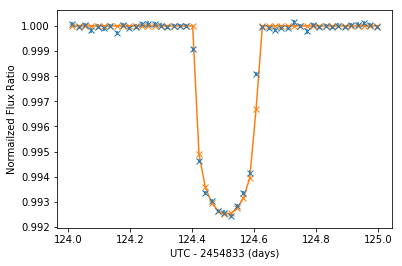

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.errorbar(t, fRatioObs, yerr=fErr, fmt='x')
ax.plot(t, flux_exp,'x-')
ax.set_xlabel("UTC - 2454833 (days)")
ax.set_ylabel("Normailzed Flux Ratio")
plt.show()

This looks like a decent fit!

In [9]:
N= len(flux_exp)
M = 3 
deg = N - M #N is the number of data points(len(flux_exp)) and M is the number of fitted parameters (3)
print ("probability of this chi-squared = ",gammaincc(deg/2,chi/2))

probability of this chi-squared =  1.09886907052e-70


### Problem 3

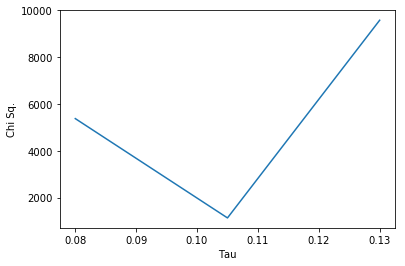

In [12]:
#Varying Tau, used .105 bc half way between .08 and .13
tau_var = np.array([.08,.105,.13])
chi2lst = []
for new_tau in tau_var:
    flux_exp = compLightCur(t, p, t0, new_tau)
    chi = chiSquared(fRatioObs, flux_exp, fErr)
    chi2lst.append(chi)
    
fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
ax2.plot(tau_var, chi2lst)
ax2.set_xlabel('Tau')
ax2.set_ylabel("Chi Squared")
plt.show()

Clearly the Tau value of .105 is the smallest tau value.

In [27]:
bestFit = np.argmin(chi2lst)
chi_best = chi2lst[bestFit]
print("Chi-Squared of {} = {}".format(tau_var[bestFit], chi_best))
print ("probability of this chi-squared = ",gammaincc((deg-1)/2, chi2lst[best_fit_index]/2))

Chi-Squared of 0.105 = 1131.178118539007
probability of this chi-squared =  1.53559163053e-207
